In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

import GPy


In [2]:
ls_model = ['simpleGP','multi-task-same-input','multi-task-coregion']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-robust','y-stand']
ls_cate_transform = ['ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]

In [3]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
#df = pd.read_csv('data/dps-alldata.csv')
df = pd.read_csv('data/dps-cleaned-missing.csv')
print(len(df))
df.head()

1843


,Import_Date,ISID,Project,Protein,Modality,Control_Type,Stress_Condition,Temp_C_,Time_Days_,Well_ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified_Excipients,1st_Excipient_in_Sample,2nd_Excipient_in_Sample,_Conc_for_Excipient1,Origin_of_data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [4]:
# Update the sample identifier 
"""
    The protein concentration may deviate one from another in an acceptable range
    Thus, we remove the Protein concentration from sample identifier
"""
cols_group = ['Project','Protein','Modality', 'Stress_Condition','Temp_C_', 'Time_Days_']

In [5]:
cols_feature01 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']
#cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']
cols_target = ['UP_SEC_HMW','UP_SEC_LMW']
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


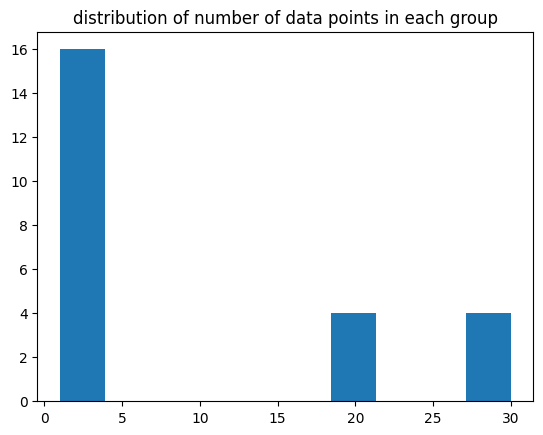

In [6]:
# split dataframe by identifiers
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits_identifier = list(df[cols_group + cols_feature01+cols_target].groupby(cols_group,dropna=is_drop_na))
#splits_identifier = list(df[cols_group + cols_cate+['pH']+cols_target].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits_identifier]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [7]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]
#split7 = splits_identifier[7] #split 7 target columns are all NAs

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)
#split7_formulation_df = split7[1][cols_feature01]
#split7_formulation_df.reset_index(drop = True,inplace =True)

print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))
#print(split5_formulation_df.equals(split7_formulation_df))

True
True


In [8]:
split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]

#split7_target_df = split7[1][cols_target]
#split7_target_df.reset_index(drop = True,inplace =True)
#split7_target_df.columns = [c+'_7' for c in split7_target_df.columns]

In [9]:
n21_total_df = pd.concat((split1_formulation_df,split1_target_df,split3_target_df,split5_target_df),axis = 1)
n21_total_df.head()

,Buffer,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,UP_SEC_HMW_1,UP_SEC_LMW_1,UP_SEC_HMW_3,UP_SEC_LMW_3,UP_SEC_HMW_5,UP_SEC_LMW_5
0,Acetate,0,0.0,0.0,0,5.0,1.45,0.47,1.06,1.67,3.86,0.93
1,Acetate,0,0.0,0.0,0,5.5,1.37,0.67,3.30,1.73,2.43,0.84
2,Acetate,0,0.0,0.0,0,6.0,1.24,0.61,3.60,1.54,1.82,0.82
3,Citrate,0,0.0,0.0,0,5.5,1.42,0.92,4.39,1.47,3.53,0.34
4,Citrate,0,0.0,0.0,0,6.0,1.63,0.34,4.59,1.40,2.90,1.06


In [10]:
#cols_target_new = ['UP_SEC_Monomer_1','UP_SEC_HMW_1',	'UP_SEC_Monomer_3',	'UP_SEC_HMW_3',	'UP_SEC_Monomer_5',	'UP_SEC_HMW_5']
cols_target_new = ['UP_SEC_HMW_1','UP_SEC_LMW_1',	'UP_SEC_HMW_3',	'UP_SEC_LMW_3','UP_SEC_HMW_5','UP_SEC_LMW_5']
#one hot encoding
ohe_n21_total_df = pd.get_dummies(n21_total_df, columns = ['Buffer'])
ohe_n21_total_df.head()

,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,UP_SEC_HMW_1,UP_SEC_LMW_1,UP_SEC_HMW_3,UP_SEC_LMW_3,UP_SEC_HMW_5,UP_SEC_LMW_5,Buffer_Acetate,Buffer_Citrate,Buffer_Histidine
0,0,0.0,0.0,0,5.0,1.45,0.47,1.06,1.67,3.86,0.93,True,False,False
1,0,0.0,0.0,0,5.5,1.37,0.67,3.30,1.73,2.43,0.84,True,False,False
2,0,0.0,0.0,0,6.0,1.24,0.61,3.60,1.54,1.82,0.82,True,False,False
3,0,0.0,0.0,0,5.5,1.42,0.92,4.39,1.47,3.53,0.34,False,True,False
4,0,0.0,0.0,0,6.0,1.63,0.34,4.59,1.40,2.90,1.06,False,True,False


In [11]:
cols_feature_new = ['Buffer_Acetate','Buffer_Citrate','Buffer_Histidine','NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH']

In [12]:
ls_X = [ohe_n21_total_df[cols_feature_new],ohe_n21_total_df[cols_feature_new],ohe_n21_total_df[cols_feature_new]]
for i,df_x in enumerate(ls_X):
    df_x['task_ind'] = i

df_X = pd.concat(ls_X)
df_X.reset_index(inplace=True, drop = True)
df_X

,Buffer_Acetate,Buffer_Citrate,Buffer_Histidine,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,task_ind
0,True,False,False,0,0.00,0.0,0,5.0,0
1,True,False,False,0,0.00,0.0,0,5.5,0
2,True,False,False,0,0.00,0.0,0,6.0,0
3,False,True,False,0,0.00,0.0,0,5.5,0
4,False,True,False,0,0.00,0.0,0,6.0,0
...,...,...,...,...,...,...,...,...,...
58,False,False,True,75,0.00,0.0,0,5.0,2
59,False,False,True,75,0.00,0.0,0,5.5,2
60,False,False,True,75,0.00,0.0,0,6.0,2
61,False,False,True,75,0.00,0.0,0,6.5,2


In [13]:
#ls_y = [ohe_n21_total_df[cols_target_new],ohe_n21_total_df[cols_target_new],ohe_n21_total_df[cols_target_new]]
#df_y = pd.concat(ls_y)
#df_y.reset_index(inplace=True, drop = True)

arr_Y = np.concatenate((split1_target_df.to_numpy(),split3_target_df.to_numpy(),split5_target_df.to_numpy()))
df_Y = pd.DataFrame(arr_Y,columns= cols_target)
df_Y


,UP_SEC_HMW,UP_SEC_LMW
0,1.45,0.47
1,1.37,0.67
2,1.24,0.61
3,1.42,0.92
4,1.63,0.34
...,...,...
58,16.45,1.59
59,7.35,0.71
60,4.08,0.53
61,2.24,0.56


In [14]:
##Split the data into training and testing sets
df_X_train, df_X_test, df_Y_train, df_Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0)

In [15]:
X_train= df_X_train.to_numpy()
Y_train = df_Y_train['UP_SEC_HMW'].to_numpy().reshape(-1,1)

In [32]:
Y_dim = Y_train.shape[1]
kern = GPy.kern.RBF(1,lengthscale=0.1)**GPy.kern.Coregionalize(input_dim=1,output_dim=3, rank=2)
m = GPy.models.GPRegression(X_train,Y_train,kern)
m.optimize(messages=True)
m

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   3.166178e+02           nan 
    00s00  0002   2.209955e+02   3.714507e+03 

    00s01  0006   1.410394e+02   2.339927e+01 
    00s02  0009   1.332568e+02   2.693275e-01 
    00s04  0017   1.326151e+02   2.150001e-03 
    00s04  0021   1.325987e+02   2.353748e-04 
    00s06  0031   1.325969e+02   1.806917e-05 
    00s07  0038   1.325968e+02   8.785159e-07 
    00s08  0042   1.325968e+02   1.198250e-07 
    00s09  0048   1.325968e+02   2.675244e-07 
Runtime:     00s09
Optimization status: Converged



GP_regression.,value,constraints,priors
mul.rbf.variance,0.1729096943740296,+ve,
mul.rbf.lengthscale,0.10000000000000002,+ve,
mul.coregion.W,"(3, 2)",,
mul.coregion.kappa,"(3,)",+ve,
Gaussian_noise.variance,10.249310467551709,+ve,


In [33]:
W = m.mul.coregion.W
print(W)

  index  |  GP_regression.mul.coregion.W  |  constraints  |  priors
  [0 0]  |                    4.78665254  |               |        
  [0 1]  |                    8.26879730  |               |        
  [1 0]  |                    3.38617750  |               |        
  [1 1]  |                    5.84966581  |               |        
  [2 0]  |                   -0.52748873  |               |        
  [2 1]  |                    0.34767781  |               |        


In [17]:
B = m.mul.coregion.B
print(B)
(B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))

[[100.01484597  70.75494095   8.07431786]
 [ 70.75494095  50.05519978   5.71211681]
 [  8.07431786   5.71211681   1.21330154]]


array([[1.        , 0.99999986, 0.73297512],
       [0.99999986, 1.        , 0.73297322],
       [0.73297512, 0.73297322, 1.        ]])

In [18]:
Y_pred_train = m.predict(X_train)
print(Y_pred_train[0].shape)
print(Y_pred_train[1].shape)

(50, 1)
(50, 1)


In [20]:
X_test= df_X_test.to_numpy()
Y_test = df_Y_test.to_numpy()

noise_dict = {'output_index':X_test[:,-1].astype(int)}

Y_pred = m.predict(X_test,Y_metadata=noise_dict)
print(Y_pred[0].shape)
print(Y_pred[1].shape)

(13, 1)
(13, 1)


In [21]:
Y_pred[0]

array([[3.42678598],
       [4.33560234],
       [4.33560234],
       [4.33560234],
       [3.42678598],
       [3.06719769],
       [4.33560234],
       [3.06719769],
       [3.42678598],
       [3.42678598],
       [3.06719769],
       [4.33560234],
       [3.06719769]])

In [22]:
Y_pred[1]

array([[10.94910639],
       [10.59506334],
       [10.59506334],
       [10.59506334],
       [10.94910639],
       [10.42242365],
       [10.59506334],
       [10.42242365],
       [10.94910639],
       [10.94910639],
       [10.42242365],
       [10.59506334],
       [10.42242365]])

In [23]:
round(metrics.root_mean_squared_error(Y_test[:,0], Y_pred[0]),2)

1.57